In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('../DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [3]:
# changing the column name to Sales
df.columns = ['Sales']

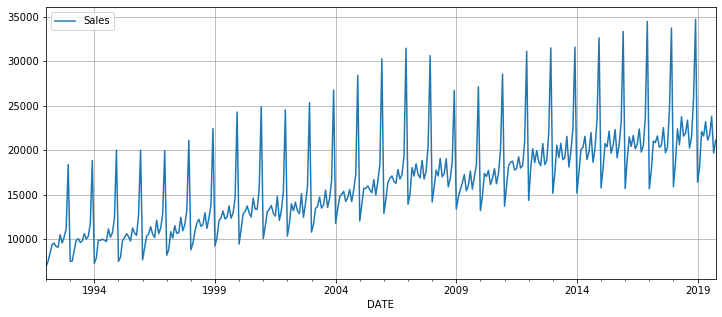

In [4]:
df.plot(figsize=(12,5), grid=True)

## Train Test Split

In [5]:
df.shape

(334, 1)

Data is monthly, let's forecast 1.5 years into the future.

In [78]:
len(df)- 18 # 1.5 years=18 months (testing data)

316

In [11]:
test_size = 18
test_ind = len(df)- test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

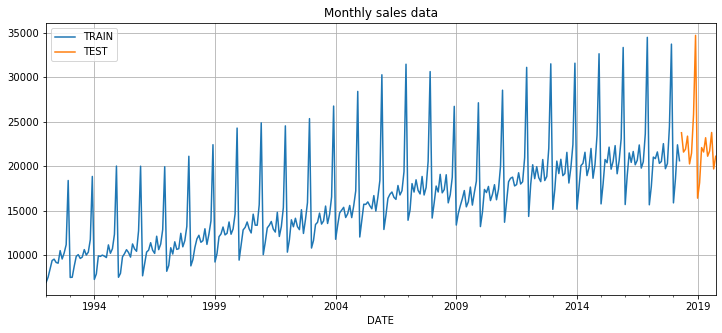

In [19]:
ax = train.plot(figsize=(12,5))
test.plot(ax=ax, grid=True);
ax.legend(['TRAIN', 'TEST'])
ax.set_title('Monthly sales data');

## Scale Data

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [21]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module tensorflow.python.keras.preprocessing.sequence:

class TimeseriesGenerator(keras_preprocessing.sequence.TimeseriesGenerator, tensorflow.python.keras.utils.data_utils.Sequence)
 |  Utility class for generating batches of temporal data.
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  # Arguments
 |      data: Indexable generator (such as list or Numpy array)
 |          containing consecutive data points (timesteps).
 |          The data should be at 2D, and axis 0 is expected
 |          to be the time dimension.
 |      targets: Targets corresponding to timesteps in `data`.
 |          It should have same length as `data`.
 |      length: Length of the output sequences (in number of timesteps).
 |      sampling_rate: Period between successive individual timesteps
 |          with

In [25]:
len(test)

18

In [34]:
# one must ensure that the length size should be less than the test size
batch_size=1 # for time series data
length = 12 # length of batches
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length, 
                                batch_size=batch_size)

In [35]:
# What does the first batch look like?
X,y = generator[0]

# Given the sales value 12 months predict for the 13th month
print('Given the Array: {} \n\n'.format(X.flatten()))
print('Predict (the next value) y: {}'.format(y))

Given the Array: [0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266] 


Predict (the next value) y: [[0.02047633]]


### Create the Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [38]:
n_features = 1

In [39]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [43]:
validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test, 
                                           length=length, batch_size=batch_size)

In [44]:
# fit model
model.fit_generator(generator,epochs=20, validation_data=validation_generator, 
                    callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 30s 97ms/step - loss: 0.0267 - val_loss: 0.0030
Epoch 2/20
304/304 [==============================] - 26s 87ms/step - loss: 0.0192 - val_loss: 0.0070
Epoch 3/20
304/304 [==============================] - 22s 71ms/step - loss: 0.0123 - val_loss: 0.0013
Epoch 4/20
304/304 [==============================] - 13s 42ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 5/20
304/304 [==============================] - 13s 44ms/step - loss: 0.0044 - val_loss: 6.1160e-04
Epoch 6/20
304/304 [==============================] - 12s 41ms/step - loss: 0.0030 - val_loss: 0.0068
Epoch 7/20
304/304 [==============================] - 12s 39ms/step - loss: 0.0028 - val_loss: 0.0033


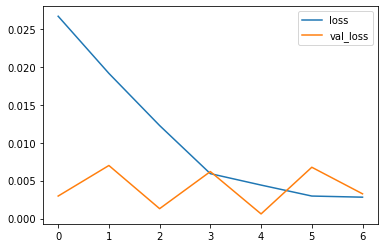

In [45]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-length:] # the very last batch (points) from the training set
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [47]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/home/dhrumpy/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


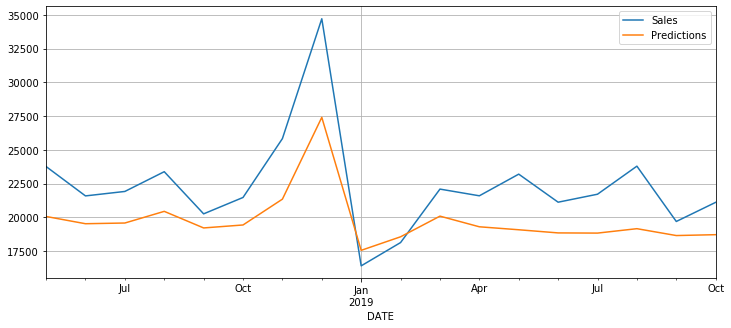

In [50]:
test.plot(figsize=(12,5), grid=True)

### Calcutale RMSE 

In [73]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test['Sales'], test['Predictions'])**0.5

3163.1404647251106

In [77]:
test['Sales'].describe()  #compare errot with the mean value

count       18.000000
mean     22321.833333
std       3762.960337
min      16410.000000
25%      21115.500000
50%      21655.500000
75%      23335.750000
max      34706.000000
Name: Sales, dtype: float64

# Retrain and Forecasting

In [51]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [53]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(data=scaled_full_data, targets=scaled_full_data, 
                                length=length, batch_size=1)

In [54]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=10)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/10
322/322 [==============================] - 14s 43ms/step - loss: 0.0214
Epoch 2/10
322/322 [==============================] - 11s 35ms/step - loss: 0.0167
Epoch 3/10
322/322 [==============================] - 12s 39ms/step - loss: 0.0152
Epoch 4/10
322/322 [==============================] - 16s 49ms/step - loss: 0.0059
Epoch 5/10
322/322 [==============================] - 12s 38ms/step - loss: 0.0030
Epoch 6/10
322/322 [==============================] - 13s 41ms/step - loss: 0.0028
Epoch 7/10
322/322 [==============================] - 12s 37ms/step - loss: 0.0020
Epoch 8/10
322/322 [==============================] - 12s 37ms/step - loss: 0.0017
Epoch 9/10
322/322 [==============================] - 12s 37ms/step - loss: 0.0011
Epoch 10/10
322/322 [==============================] - 12s 38ms/step - loss: 0.0014


In [62]:
forecast = []
periods = 24

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):    
    current_pred = model.predict(current_batch)[0]    
    forecast.append(current_pred)     
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [63]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [64]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index, columns=['Forecast'])

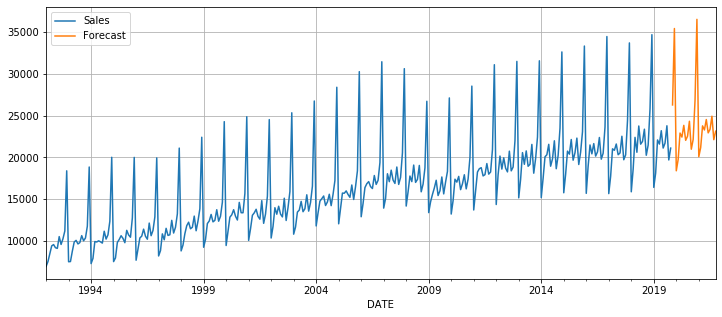

In [68]:
ax = df.plot(figsize=(12,5))
forecast_df.plot(ax=ax, grid=True)

In [79]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01'],
              dtype='datetime64[ns]', name='DATE', length=334, freq=None)